# League of Legends Ward Correlation Analysis

**Name(s)**: Jacob Doan, Vanessa Feng

**Website Link**: (your website link)

In [13]:
# Add utils to system path so we can import from there
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))

# Required Imports
import pandas as pd
import numpy as np
from pathlib import Path

import plotly.express as px
pd.options.plotting.backend = 'plotly'

from dsc80_utils import * # Feel free to uncomment and use this.

# Additional Imports
import plotly.graph_objects as go
from scipy.stats import gaussian_kde

## Step 1: Introduction

In [15]:
output = ("League of Legends (LoL) is a strategic & competitive teamwork-oriented game where 2 teams of 5 players compete to destroy the opposing team’s base. Success depends not only on mechanical skill but also a variety of other factors: map control, resource management, teamwork, etc. For this project, we are working with a LoL match dataset from Oracle’s Elixir (2024 competitive season). The dataset captures match outcomes and various statistics, including kills, deaths, assists, team gold, dragons secured, towers destroyed, and in-depth vision metrics like wards placed and wards cleared. Some of the questions that interested us include: How does objective control influence win rates? How much can vision control influence win rates? Are there particular metrics that are especially predictive of success? We decided to analyze: What is the optimal number of wards placed per minute (WPM) that maximizes a team’s probability of winning? In LoL, 'wards' are deployable vision tools that reveal areas of the map, enabling teams to track movements of the enemy team. Vision control is a critical component of the game, but the  relationship between wards and win rate is not always obvious—placing more wards could improve map awareness, but excessive warding might also be wasted resources or time. By analyzing the connection between wards placed per minute and match outcomes, we aim to identify if there’s a sweet spot where vision control most strongly correlates with winning, and whether there is a point of diminishing returns.")
output

"League of Legends (LoL) is a strategic & competitive teamwork-oriented game where 2 teams of 5 players compete to destroy the opposing team’s base. Success depends not only on mechanical skill but also a variety of other factors: map control, resource management, teamwork, etc. For this project, we are working with a LoL match dataset from Oracle’s Elixir (2024 competitive season). The dataset captures match outcomes and various statistics, including kills, deaths, assists, team gold, dragons secured, towers destroyed, and in-depth vision metrics like wards placed and wards cleared. Some of the questions that interested us include: How does objective control influence win rates? How much can vision control influence win rates? Are there particular metrics that are especially predictive of success? We decided to analyze: What is the optimal number of wards placed per minute (WPM) that maximizes a team’s probability of winning? In LoL, 'wards' are deployable vision tools that reveal are

## Step 2: Data Cleaning and Exploratory Data Analysis

Here, we will take a first look at our only dataset: A League of Legends Esports Match Data taken from OracleElixir during 2024.

In [16]:
df = pd.read_csv('../data/2024_LoL_esports_match_data_from_OraclesElixir.csv')
df

C:\Users\Jacob Doan\AppData\Local\Temp\ipykernel_11932\2444245145.py:1: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



,gameid,datacompleteness,url,league,...,deathsat25,opp_killsat25,opp_assistsat25,opp_deathsat25
0,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,...,NaN,NaN,NaN,NaN
1,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,...,NaN,NaN,NaN,NaN
2,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
117645,LOLTMNT02_194401,complete,NaN,KeSPA,...,2.0,0.0,5.0,2.0
117646,LOLTMNT02_194401,complete,NaN,KeSPA,...,7.0,7.0,9.0,8.0
117647,LOLTMNT02_194401,complete,NaN,KeSPA,...,8.0,8.0,16.0,7.0


There seems to be a lot of columns... **161** to be exact. Most of these columns are irrelevant at this stage of investigating our question, so we will include only examine, clean, and plot the relevant columns for now for a better understanding.

With a simple for loop:

```
for i in df.columns:
    print(i)
```

Upon a manual inspection, some columns appear to be relevant:

1. **gameid** (string): the id of the match that two teams played in against each other.
2. **playerid** (string): the player on that team for the current match.
3. **teamid** (string): the id of the team that played in that match.
4. **wardsplaced** (int): the total number of wards placed by everyone in that team for the entire match.
5. **gamelength** (int): the number of seconds that the match took.
6. **wpm** (float): the average rate of number of wards placed per minute by a team.
  - Note: this column was already given to us.
  - However, a person can get a similar value by converting the gamelength value into minutes, and then dividing wardsplaced by gamelength in minutes.
  - Example: 1886 seconds * 60 = 31.43 minutes.
  - 14 wards placed / 31.43 minutes = 0.45 wards placed per minute
7. **result** (integer): whether a team won that match. 1 represents a win, 0 reprsents a loss.

In [17]:
relevant_df = df[['gameid', 'playerid', 'teamid', 'wardsplaced', 'gamelength', 'wpm', 'result']]
relevant_df

,gameid,playerid,teamid,wardsplaced,gamelength,wpm,result
0,10660-10660_game_1,oe:player:65ed20b21e2993fb00dbd21a2fd991b,oe:team:a9145b7711873f53e610fbba0493484,14,1886,0.45,0
1,10660-10660_game_1,oe:player:57da8dfcfbdb4e5b019fe93003db1c4,oe:team:a9145b7711873f53e610fbba0493484,10,1886,0.32,0
2,10660-10660_game_1,oe:player:71e79ef80600d398d90cfebe3b0b758,oe:team:a9145b7711873f53e610fbba0493484,4,1886,0.13,0
...,...,...,...,...,...,...,...
117645,LOLTMNT02_194401,oe:player:3126bca5d4d2555ba3b460699508e16,oe:team:66eccb6faca7fd5e3cdf4ccf903385c,81,2546,1.91,1
117646,LOLTMNT02_194401,NaN,oe:team:2a247555001e6364757f171f158f997,146,2546,3.44,0
117647,LOLTMNT02_194401,NaN,oe:team:66eccb6faca7fd5e3cdf4ccf903385c,158,2546,3.72,1


We can start cleaning this data frame by ensuring the following:

1. We must verify that wardsplaced, gamelength, and wpm are all greater than or equal to 0.
  - This is because there cannot be a negative number of wards placed in a game, the minimum is 0.
  - Likewise a game must last at least greater than 0 seconds. This makes sense intutively, and also because to calculate wpm, we cannot divide by 0.
  - And finally, wpm, representing a proportion, cannot be negative.
2. We must verify that all wpm is an accurate reprsentation of the wardsplaced and gamelength columns.
  - This means we must check whether wpm = wardsplaced / (gamelength / 60)
3. We must verify that the results column consists of either only 1s or 0s
  - Anything other than that would be incorrect, as it wouldn't represent a win or loss.

On a side note, we are leaving gameid, playerid, and teamid alone for now. They are strings with no inherent restrictions on them, unlike the columns with numerical representation of certain values. Even if there is missing data, we will address them in a later section.

In [18]:
print(np.all((relevant_df['wardsplaced'] >= 0)))
print(np.all((relevant_df['gamelength'] >= 0)))
print(np.all((relevant_df['wpm'] >= 0)))
recalculated_wpm = relevant_df['wardsplaced'] / (relevant_df['gamelength'] / 60)
print(np.all(np.isclose(recalculated_wpm, relevant_df['wpm'], atol=0.01)))
print(relevant_df['result'].isin([0, 1]).all())

True
True
True
True
True


It seems like there are no incorrectly formatted data within our relevant dataset that needs to be corrected at this time. This means out dataset was already given to us clean. Thank goodness!

Before, we can begin aggregating this dataframe, we need to understand the influence of the column playerid. Let's take a snippet of just ONE game for example. We will use gameid "10660-10660_game_1" for this demonstration.

In [19]:
df[df['gameid'] == '10660-10660_game_1'][['gameid', 'playerid', 'teamid', 'wardsplaced', 'gamelength', 'wpm', 'result']]

,gameid,playerid,teamid,wardsplaced,gamelength,wpm,result
0,10660-10660_game_1,oe:player:65ed20b21e2993fb00dbd21a2fd991b,oe:team:a9145b7711873f53e610fbba0493484,14,1886,0.45,0
1,10660-10660_game_1,oe:player:57da8dfcfbdb4e5b019fe93003db1c4,oe:team:a9145b7711873f53e610fbba0493484,10,1886,0.32,0
2,10660-10660_game_1,oe:player:71e79ef80600d398d90cfebe3b0b758,oe:team:a9145b7711873f53e610fbba0493484,4,1886,0.13,0
...,...,...,...,...,...,...,...
9,10660-10660_game_1,oe:player:937dc5479c6416d1ad4997538144f6e,oe:team:8516ca63facc91286d6c00212ca945e,76,1886,2.42,1
10,10660-10660_game_1,NaN,oe:team:a9145b7711873f53e610fbba0493484,97,1886,3.09,0
11,10660-10660_game_1,NaN,oe:team:8516ca63facc91286d6c00212ca945e,122,1886,3.88,1


Notice how each row represents a PLAYER'S statistics. Our goal is to find the optimal wards placed per minute by TEAM overall. Each player on a team has different roles, so naturally some players may place a different rate of wpm than others depending on how much they are supposed to support the team.

Thus, we will groupby the relevant dataframe to show us each team's average wpm, and whether they won or lost, in a specific game.

Note: if a team won or lost, then all players in their team should share the same result value. Thus, results can only be a 1 or 0.

In [20]:
grouped = relevant_df.groupby(['gameid', 'teamid']).agg({
    'wpm': 'mean',
    'result': 'mean'
}).reset_index()

# do this because groupby mean causes it to become a float
grouped['result'] = grouped['result'].astype(int)

grouped

,gameid,teamid,wpm,result
0,10660-10660_game_1,oe:team:8516ca63facc91286d6c00212ca945e,1.29,1
1,10660-10660_game_1,oe:team:a9145b7711873f53e610fbba0493484,1.03,0
2,10660-10660_game_2,oe:team:8516ca63facc91286d6c00212ca945e,1.21,1
...,...,...,...,...
19153,LOLTMNT99_148130,oe:team:5203ff881d5c82c5f720eb3a2f3b44c,0.97,1
19154,LOLTMNT99_148194,oe:team:1bcba9d314932379a955b3de9e8654d,1.34,0
19155,LOLTMNT99_148194,oe:team:28428f3022fc1ea52264b35912093dc,1.21,1


We can double check this to make sure.

In [21]:
print(grouped['result'].isin([0, 1]).all())

True


This looks way more organized! Let's perform a univarate analysis just to visualize the distribution of wpm, regardless of whether a team won or lost.

wpm being a proportion makes itself a continuous variable, unlike wardsplaced or gamelength which are represented by discrete values. So, we will be visualizing these distributions with a KDE plot

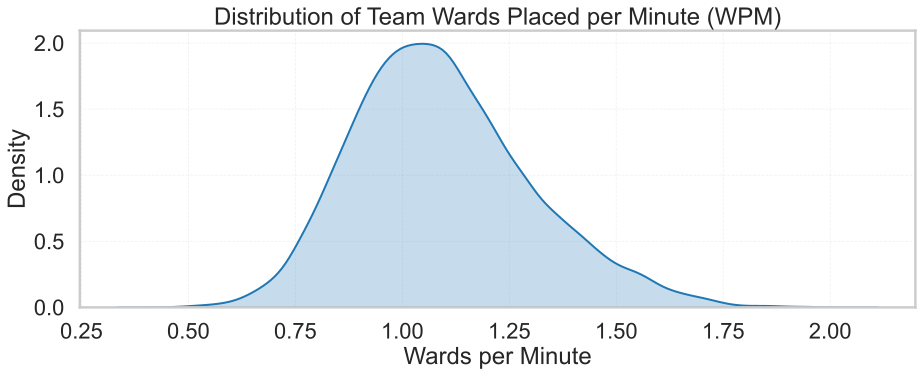

In [22]:
plt.figure(figsize=(15, 5))
sns.kdeplot(grouped['wpm'], fill=True)
plt.title("Distribution of Team Wards Placed per Minute (WPM)")
plt.xlabel("Wards per Minute")
plt.ylabel("Density")
plt.grid(visible=True, linestyle='--', linewidth=0.8, alpha=0.3)
plt.show()

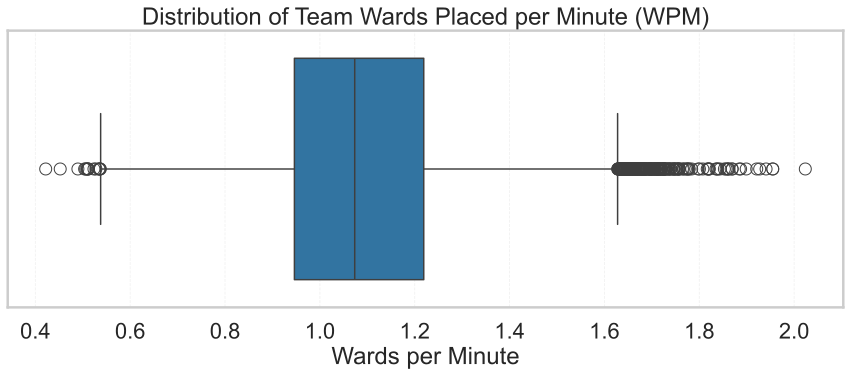

In [23]:
plt.figure(figsize=(15, 5))
sns.boxplot(x=grouped['wpm'], linewidth=1.5)
plt.title("Distribution of Team Wards Placed per Minute (WPM)")
plt.xlabel("Wards per Minute")
plt.yticks([])
plt.grid(visible=True, linestyle='--', linewidth=0.8, alpha=0.3)
plt.show()

Now, let's see if there is a glaring difference at first sight between the wdm of teams that won, and the wdm of teams that lost.

In [24]:
wpm_win = grouped[grouped['result'] == 1]['wpm']
wpm_loss = grouped[grouped['result'] == 0]['wpm']

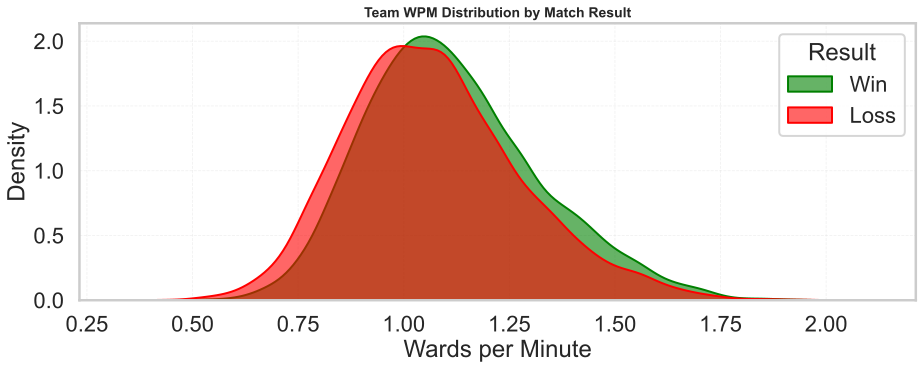

In [25]:
plt.figure(figsize=(15, 5))

sns.kdeplot(wpm_win, fill=True, label='Win', color='green', alpha=0.6, linewidth=2)
sns.kdeplot(wpm_loss, fill=True, label='Loss', color='red', alpha=0.6, linewidth=2)

plt.title("Team WPM Distribution by Match Result", fontsize=14, fontweight='bold')
plt.xlabel("Wards per Minute")
plt.ylabel("Density")
plt.grid(visible=True, linestyle='--', linewidth=0.8, alpha=0.3)
plt.legend(title="Result", loc="upper right")
plt.show()

As for the boxplot, we need to add an extra column called result_str, because Seaborne expects the palette keys to exactly match the unique values in the y='result' column, and if they don’t, it raises a ValueError. To prevent possible errors, we will make this new column and map it to the boxplot.

C:\Users\Jacob Doan\AppData\Local\Temp\ipykernel_11932\585939008.py:18: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



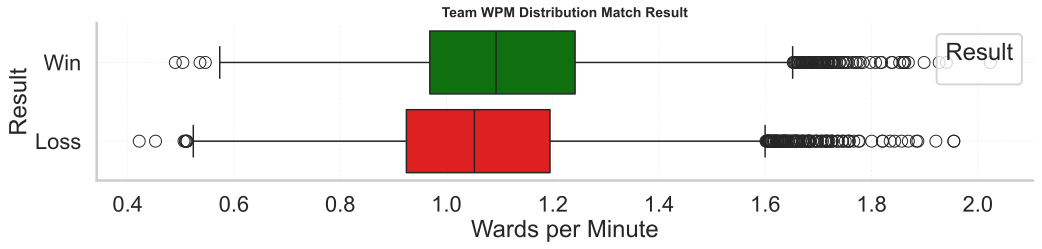

In [26]:
grouped['result_str'] = grouped['result'].map({1: 'Win', 0: 'Loss'})

plt.figure(figsize=(15, 4))

sns.boxplot(
    data=grouped,
    x='wpm',
    y='result_str',
    hue='result_str',
    palette={'Win': 'green', 'Loss': 'red'},
    linewidth=1.5,
    dodge=False
)

plt.title("Team WPM Distribution Match Result", fontsize=14, fontweight='bold')
plt.xlabel("Wards per Minute")
plt.ylabel("Result")
plt.legend(title='Result', loc='upper right')
plt.grid(visible=True, linestyle='--', linewidth=0.8, alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()

## Step 3: Assessment of Missingness

In [ ]:
df.columns.tolist()
# df["gameid",""]

KeyError: ('gameid', '')

## Step 4: Hypothesis Testing

In [ ]:
# TODO

## Step 5: Framing a Prediction Problem

In [ ]:
# TODO

## Step 6: Baseline Model

In [ ]:
# TODO

## Step 7: Final Model

In [ ]:
# TODO

## Step 8: Fairness Analysis

In [ ]:
# TODO